<a href="https://colab.research.google.com/github/ahzaidy/Programs/blob/main/CPSC_5440_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading preprocessed data...
Loading pre-trained model...


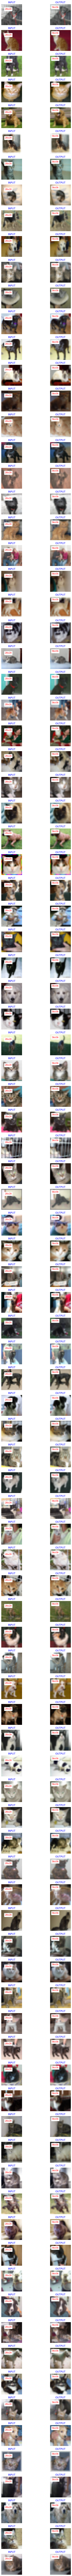

High Quality: 100 images
Moderate Quality: 0 images
Low Quality: 0 images


In [ ]:
###############################################################################
#Author: Arif H. Zaidy                                                        #
#Date: March 19, 2025                                                         #
#Course: CPSC 5440                                                            #
#Topic: Assignment 3                                                          #
#Description:                                                                 #
#The code implements an image upscaling logic using a PyTorch autoencoder. It #
#defines a custom dataset class to load low-resolution images (28x28) and     #
#upscale them to higher resolution (56x56).The autoencoder has a convolutional#
#encoder-decoder structure with downsampling and upsampling layers.The model  #
#is trained using MSE loss and evaluated using MSE and SSIM to measure        #
#reconstruction quality. Results are categorized into High, Moderate, and     #
#Low Quality based on thresholds. To avoid performance issues only 100 out of #
#12,500 images from the test dataset are processed and displayed on the       #
#console below. To get better resolution the epochs should be increased to    #
#atleast 50. In my case, I am using 20 but the program still takes an hour to #
#execute.                                                                     #
###############################################################################

# Importing Python libraries

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount("/content/drive")

# Set paths
train_dir = "/content/drive/My Drive/train/"
test_dir = "/content/drive/My Drive/test1/"
train_data_path = "/content/drive/My Drive/train_data.npy"
test_data_path = "/content/drive/My Drive/test_data.npy"
model_path = "/content/drive/My Drive/autoencoder.pth"

# Dataset class
class ImageDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

# Load or create dataset
input_size = (28, 28)

if os.path.exists(train_data_path) and os.path.exists(test_data_path):
    print("Loading preprocessed data...")
    train_data = np.load(train_data_path)
    test_data = np.load(test_data_path)
else:
    print("Processing images from directory...")

    # Load training data
    train_transform = transforms.Compose([
        transforms.Resize(input_size),
        transforms.ToTensor()
    ])
    train_images = []
    for file in os.listdir(train_dir):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(train_dir, file)).convert('RGB')
            img_tensor = train_transform(img)
            train_images.append(img_tensor.numpy())
    train_data = np.array(train_images)

    # Load test data
    test_images = []
    for file in os.listdir(test_dir):
        if file.endswith(('.jpg', '.png', '.jpeg')):
            img = Image.open(os.path.join(test_dir, file)).convert('RGB')
            img_tensor = train_transform(img)
            test_images.append(img_tensor.numpy())
    test_data = np.array(test_images)

    # Save data for future use
    np.save(train_data_path, train_data)
    np.save(test_data_path, test_data)
    print("Data saved to disk.")

# Create DataLoader
batch_size = 64
train_dataset = ImageDataset(train_data)
test_dataset = ImageDataset(test_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder: The encoder is responsible for compressing the input into a lower-dimensional latent representation
        # Input: 28x28x3 (RGB Image)
        # Output: 28x28x64 (feature map of size 28x28 with 64 channels)

        # First Convolutional Layer: Converts input from 3 channels (RGB) to 32 channels
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),  # 28x28x3 → 28x28x32
            nn.ReLU(),  # Activation function to introduce non-linearity
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 28x28x32 → 28x28x64
            nn.ReLU()  # Activation function
        )

        # Decoder: The decoder takes the feature map from the encoder and reconstructs the image
        # Input: 28x28x64 (compressed feature map from the encoder)
        # Output: 56x56x3 (reconstructed RGB image)

        # First Convolutional Layer in Decoder: Converts from 64 channels to 32 channels
        # Upsampling: The image is upsampled to 56x56 (from 28x28)
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=3, padding=1),  # 28x28x64 → 28x28x32
            nn.ReLU(),  # Activation function
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),  # Upsample: 28x28 → 56x56
            nn.Conv2d(32, 3, kernel_size=3, padding=1),  # 56x56x32 → 56x56x3 (reconstructed output)
            nn.Sigmoid()  # Sigmoid activation to ensure output pixel values are in the range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)  # Encode input
        x = self.decoder(x)  # Decode input

        return x



# Initialize model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load or train model
if os.path.exists(model_path):
    print("Loading pre-trained model...")
    model = torch.load(model_path, weights_only=False)  # Set weights_only to False
else:
    print("Training new model...")
    model = Autoencoder().to(device)

    # Define loss and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train model
    epochs = 20
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        for input_batch in train_loader:
            input_batch = input_batch.to(device)
            optimizer.zero_grad()
            outputs = model(input_batch)
            loss = criterion(outputs, F.interpolate(input_batch, size=(56, 56), mode='bilinear'))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {epoch_loss / len(train_loader):.4f}")

    # Save the trained model
    torch.save(model, model_path)
    print("Model saved.")

# Evaluate model
model.eval()
mse_values, ssim_values = [], []
categories = {"High Quality": [], "Moderate Quality": [], "Low Quality": []}
mse_thresholds, ssim_thresholds = [0.005, 0.02], [0.85, 0.65]

# Plot 50 test images with reconstruction and show their sizes
fig, axes = plt.subplots(100, 2, figsize=(10, 200))
image_count = 0

for input_batch in test_loader:
    if image_count >= 100:
        break
    with torch.no_grad():
        input_batch = input_batch.to(device)  # Move the input batch directly to the device
        output = model(input_batch).cpu().numpy()

    for j in range(input_batch.shape[0]):
        if image_count >= 100:
            break
        original = input_batch[j].cpu().numpy().transpose(1, 2, 0)  # Original input image (28x28)
        recon = output[j].transpose(1, 2, 0)  # Reconstructed output (56x56)

        # Ensure both original and reconstructed images are the same size for comparison
        original_resized = F.interpolate(torch.tensor(original).unsqueeze(0).permute(0, 3, 1, 2), size=(56, 56), mode='bilinear', align_corners=False).squeeze().permute(1, 2, 0).numpy()

        mse = mean_squared_error(original_resized.flatten(), recon.flatten())
        ssim_index = ssim(original_resized, recon, data_range=1.0, channel_axis=-1)

        # Classify quality
        category = "High Quality" if mse < mse_thresholds[0] and ssim_index > ssim_thresholds[0] else \
                   "Moderate Quality" if mse < mse_thresholds[1] and ssim_index > ssim_thresholds[1] else \
                   "Low Quality"
        categories[category].append(image_count)

        # Plot original and reconstructed with sizes using 'extent' to control image size
        axes[image_count, 0].imshow(original, extent=[0, 28, 28, 0])  # INPUT image (28x28)
        axes[image_count, 1].imshow(recon, extent=[0, 56, 56, 0])  # OUTPUT image (56x56)

        # Set aspect ratio to ensure images are not distorted
        axes[image_count, 0].set_aspect('equal')  # Input image: 28x28 aspect ratio
        axes[image_count, 1].set_aspect('equal')  # Output image: 56x56 aspect ratio

        # Set limits to ensure the images are not resized automatically
        axes[image_count, 0].set_xlim(0, 28)  # For input image
        axes[image_count, 0].set_ylim(28, 0)  # For input image (flip y-axis)

        axes[image_count, 1].set_xlim(0, 56)  # For output image
        axes[image_count, 1].set_ylim(56, 0)  # For output image (flip y-axis)

        axes[image_count, 0].set_title('INPUT', fontsize=14, color='blue')
        axes[image_count, 1].set_title('OUTPUT', fontsize=14, color='blue')

        # Add text to show sizes on the images
        axes[image_count, 0].text(5, 5, f'{original.shape[0]}x{original.shape[1]}', color='red', fontsize=12, ha='left', va='top', backgroundcolor='white')

        axes[image_count, 1].text(5, 5, f'{recon.shape[0]}x{recon.shape[1]}', color='red', fontsize=12, ha='left', va='top', backgroundcolor='white')

        axes[image_count, 0].axis('off')
        axes[image_count, 1].axis('off')
        image_count += 1

plt.tight_layout()
plt.show()

# Print results
for category, indices in categories.items():
    print(f"{category}: {len(indices)} images")